In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ts_profiles.pkl to ts_profiles.pkl


In [ ]:
!pip install scikit-gstat

     |████████████████████████████████| 71kB 2.4MB/s 
  Created wheel for scikit-gstat: filename=scikit_gstat-0.3.0-cp36-none-any.whl size=70717 sha256=3117c4306968b3ab1ef84f822ac05a17ef88824a868ba87b0e0d68955c15650d
  Stored in directory: /root/.cache/pip/wheels/3c/cc/2c/0bd8139671cab9f53ea7635c20c11f747841d5057c412a482c
Successfully built scikit-gstat


In [1]:
import pickle
import numpy as np
import os
import  matplotlib.pyplot as plt
import random as rd
from sklearn.metrics.pairwise import euclidean_distances
from skgstat import Variogram

In [41]:
class LIGHT_PROF():
    def __init__(self, temp, salt, depth, lon, lat, date):
        self.salt = salt
        self.temp = temp
        self.depth = depth
        self.lon = lon
        self.lat = lat
        self.date = date

    def surface_temp(self):
        return self.temp[-1]


def get_long_lats(PROFS):
    """returns a 2D array of shape (2, N_profiles), set of (long, lat) coordinates"""
    return np.array([get_longs(PROFS), get_lats(PROFS)]).T


def get_longs(PROFS):
    return np.array([p.lon for p in PROFS])


def get_lats(PROFS):
    return np.array([p.lat for p in PROFS])


def get_surf_salt(PROFS):
    return np.array([p.salt[-1] for p in PROFS])


def get_surf_temp(PROFS):
    return np.array([p.temp[-1] for p in PROFS])


def get_date(PROFS):
    return np.array([transform_string_date_into_integer(p.date) for p in PROFS])

  
file = 'ts_profiles.pkl'
with open(file, 'rb') as f:
    PROFS = pickle.load(f)
n = len(PROFS)
s =  n #4000 #Sample size
n_lags = 20 #number of bins
np.random.seed(45)

X = get_long_lats(PROFS)
X_s = X[:s]
#np.random.shuffle(X_s)

Y = get_surf_temp(PROFS)
Y_s = Y[:s]
#np.random.shuffle(Y_s)

print("nombre de profile = ",n )

nombre de profile =  16730


[  1   1   1 ... 365 365 365]


(array([1320., 2411., 3179., 4492., 1252.,  950.,  431., 1336.,  586.,
         773.]),
 array([  1. ,  37.4,  73.8, 110.2, 146.6, 183. , 219.4, 255.8, 292.2,
        328.6, 365. ]),
 <a list of 10 Patch objects>)

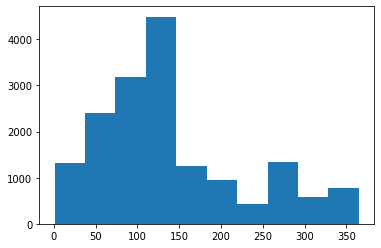

In [39]:
def transform_string_date_into_integer(date):
    """IN : string in the form AAAA-MM-JJ 00:00:00 representing a date
    OUT : integer, day 1 is 2013-01-01"""
    date = str(date)
    year, month, day = date.split('-')
    day, _ = day.split(' ')
    year, month, day = int(year), int(month), int(day)
    lenght_of_months = [31,28,31,30,31,30,31,31,30,31,30,31]
    x = 365*(year-2013) + sum(lenght_of_months[:month-1]) + day
    return x


spherical
gaussian
stable


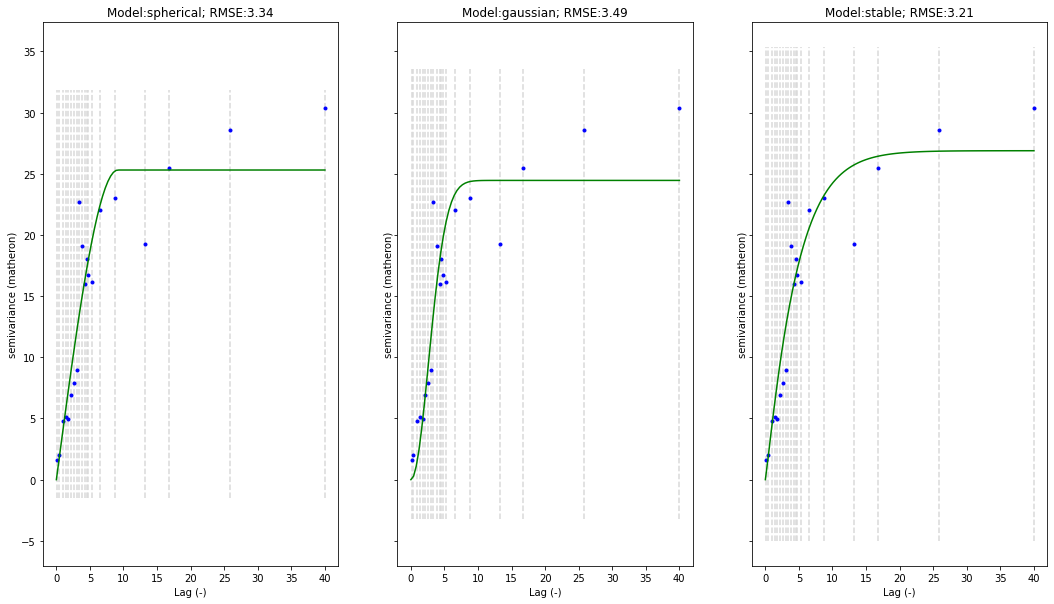

In [ ]:
V = Variogram(X_s,Y_s, n_lags = n_lags)
V.set_bin_func('uniform')

fig, _a = plt.subplots(1,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()

#for i,model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable','cubic')):
for i,model in enumerate(('spherical', 'gaussian', 'stable')):
    print(model)
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model:%s; RMSE:%.2f' % (model, V.rmse))


In [8]:
V2 = Variogram(X_s,Y_s, n_lags = n_lags)


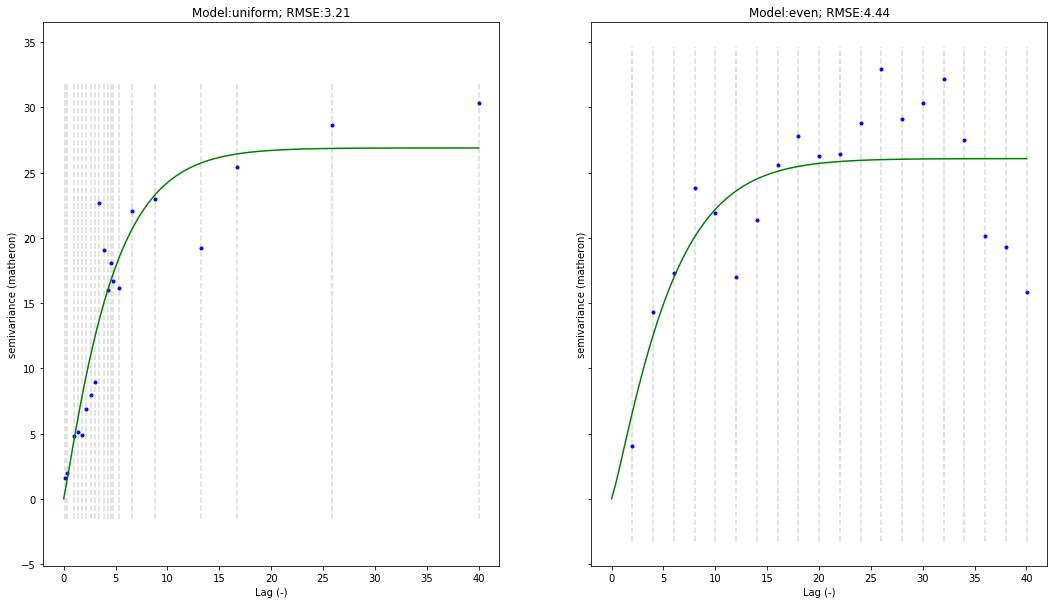

In [9]:
fig, _a = plt.subplots(1,2, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()
V2.model = 'stable'
for i, funct in enumerate(('uniform', 'even')):
    V2.model = 'stable'
    V2.set_bin_func(funct)
    V2.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model:%s; RMSE:%.2f' % (funct, V2.rmse))

In [27]:
from sklearn.model_selection import train_test_split
from skgstat import OrdinaryKriging
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)


In [28]:
print(np.shape(y_test))


(3346,)


In [12]:
V3 = Variogram(X_train,y_train, n_lags = n_lags, bin_func = 'uniform',model ='stable')

In [30]:
ok = OrdinaryKriging(V3, min_points = 5, max_points = 15, mode = 'exact')
y_predicted  = ok.transform(X_test[:,0],X_test[:,1])
print(y_predicted)

[15.8022943  13.55604172 13.88672518 ... 13.96491155 12.39824265
 22.83577476]


In [32]:
#erreur moyenne
print(np.linalg.norm(y_predicted - y_test)/len(y_test))

0.04494309592423625


In [33]:
print(y_test-y_predicted)

[ 7.21113534e+00  3.64580127e-02 -2.75725123e-01 ...  9.28688912e-01
  1.47825748e+00 -6.47483155e-03]


(array([2.506e+03, 3.170e+02, 1.570e+02, 1.070e+02, 8.800e+01, 7.800e+01,
        4.600e+01, 3.500e+01, 1.000e+01, 2.000e+00]),
 array([7.10542736e-15, 1.36563316e+00, 2.73126632e+00, 4.09689947e+00,
        5.46253263e+00, 6.82816579e+00, 8.19379895e+00, 9.55943211e+00,
        1.09250653e+01, 1.22906984e+01, 1.36563316e+01]),
 <a list of 10 Patch objects>)

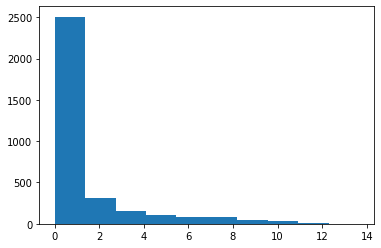

In [34]:
plt.hist(np.abs(y_predicted-y_test))

(array([   3.,   31.,   87.,  101.,  303., 2427.,  223.,   91.,   48.,
          32.]), array([-13.65633158, -11.11026834,  -8.56420511,  -6.01814187,
         -3.47207864,  -0.9260154 ,   1.62004783,   4.16611107,
          6.7121743 ,   9.25823754,  11.80430077]), <a list of 10 Patch objects>)

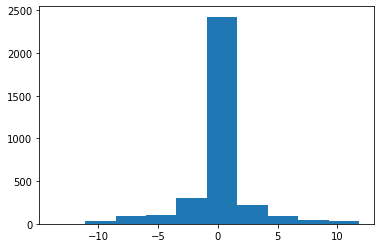

In [35]:
plt.hist(y_predicted-y_test)

(array([1320., 2411., 3179., 4492., 1252.,  950.,  431., 1336.,  586.,
         773.]),
 array([  1. ,  37.4,  73.8, 110.2, 146.6, 183. , 219.4, 255.8, 292.2,
        328.6, 365. ]),
 <a list of 10 Patch objects>)

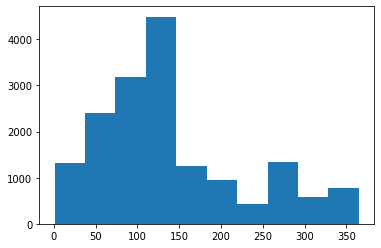

In [45]:
datation = get_date(PROFS)
plt.hist(datation)

In [47]:
def get_profs_by_date(PROFS,date1,date2):
    return [p for p in PROFS if transform_string_date_into_integer(p.date) > date1 & transform_string_date_into_integer(p.date) < date2 ]
sample_profs = get_profs_by_date(PROFS, 110, 150)
X = get_long_lats(sample_profs)
Y = get_surf_temp(sample_profs)
print(np.shape(X))

(14722, 2)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
V4 = Variogram(X_train,y_train, n_lags = n_lags, bin_func = 'uniform',model ='stable')
ok = OrdinaryKriging(V4, min_points = 5, max_points = 15, mode = 'exact')
y_predicted  = ok.transform(X_test[:,0],X_test[:,1])

In [50]:
print(np.linalg.norm(y_test - y_predicted)/len(y_test))

0.0487598134090166


(array([  19.,   47.,   97.,  155., 2012.,  435.,   96.,   57.,   22.,
           5.]), array([-12.93664501, -10.24583342,  -7.55502184,  -4.86421025,
         -2.17339867,   0.51741292,   3.20822451,   5.89903609,
          8.58984768,  11.28065927,  13.97147085]), <a list of 10 Patch objects>)

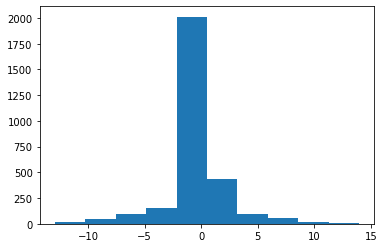

In [51]:
plt.hist(y_predicted-y_test)

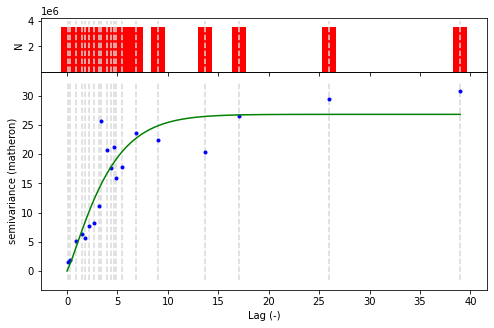

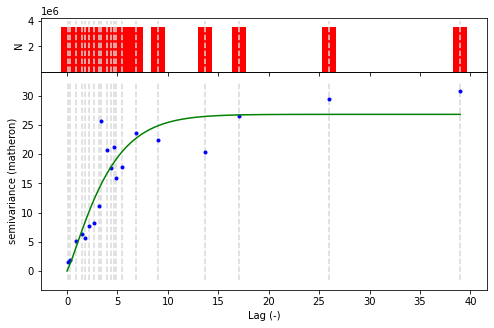

In [53]:
V4.plot()


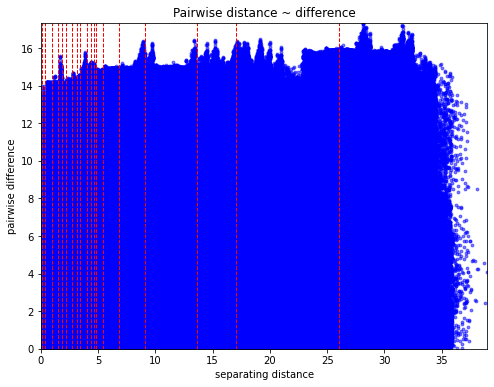

In [ ]:
V4.distance_difference_plot()